In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import logistic_regression_util

import sklearn.linear_model
import sklearn.model_selection

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import graphviz
from graphviz import Graph

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_titanic_data
from prepare import prep_titanic_data


## Mini Exercise

1. Load the titanic dataset that you've put together from previous lessons.
2. Split your data into training and test.
3. Fit a logistic regression model on your training data using sklearn's
   linear_model.LogisticRegression class. Use fare and pclass as the
   predictors.
4. Use the model's `.predict` method. What is the output?
5. Use the model's `.predict_proba` method. What is the output? Why do you
   think it is shaped like this?
6. Evaluate your model's predictions on the test data set. How accurate
   is the mode? How does changing the threshold affect this?

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic = sns.load_dataset('titanic')[['fare', 'pclass', 'survived']]
train, test = train_test_split(titanic, random_state=123, train_size=.8)

X = train[['fare', 'pclass']]
y = train.survived

model = LogisticRegression(random_state=123).fit(X, y)

In [3]:
# unique values from the y variable
model.classes_

array([0, 1])

In [4]:
pd.DataFrame(model.predict_proba(X), columns=model.classes_)

,0,1
0,0.373222,0.626778
1,0.738207,0.261793
2,0.738643,0.261357
3,0.738220,0.261780
4,0.367825,0.632175
...,...,...
707,0.574824,0.425176
708,0.585981,0.414019
709,0.738061,0.261939
710,0.738622,0.261378


In [5]:
train['yhat'] = model.predict(X)
train['p_survived'] = model.predict_proba(X)[:, 1]

In [6]:
model.score(X, y)

0.672752808988764

In [7]:
accuracy_score(train.survived, train.yhat)

0.672752808988764

In [8]:
precision_score(train.survived, train.yhat, average=None)

array([0.68498168, 0.63253012])

In [9]:
recall_score(train.survived, train.yhat)

0.37906137184115524

In [10]:
t = .25
train['yhat'] = train.p_survived > t

accuracy_score(train.survived, train.yhat), precision_score(train.survived, train.yhat), recall_score(train.survived, train.yhat)

(0.3890449438202247, 0.3890449438202247, 1.0)

## More Complicated Example

- **validate data split** lets us compare models, tweak hyperparams, experiment with thresholds without leaking information from the test split
- train: fit models -- majority of our data
- validate: compare models, choose hyperparams, thresholds -- ~ 20% of our data
- test: to get an idea of *out of sample error* -- ~20% of our data

In [11]:
df = sns.load_dataset('titanic')[['fare', 'sex', 'pclass', 'survived']]
df.head()

,fare,sex,pclass,survived
0,7.2500,male,3,0
1,71.2833,female,1,1
2,7.9250,female,3,1
3,53.1000,female,1,1
4,8.0500,male,3,0


In [12]:
train, test = train_test_split(df, random_state=123, train_size=.86)
train, validate = train_test_split(train, random_state=123, train_size=.83)

print('    test: %d rows x %d columns' % test.shape)
print('   train: %d rows x %d columns' % train.shape)
print('validate: %d rows x %d columns' % validate.shape)

    test: 125 rows x 4 columns
   train: 635 rows x 4 columns
validate: 131 rows x 4 columns


In [13]:
model = smf.logit('survived ~ fare + sex + pclass', train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.465616
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  635
Model:                          Logit   Df Residuals:                      631
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Apr 2020   Pseudo R-squ.:                  0.3088
Time:                        06:34:20   Log-Likelihood:                -295.67
converged:                       True   LL-Null:                       -427.76
Covariance Type:            nonrobust   LLR p-value:                 5.559e-57
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3313      0.442      7.534      0.000       2.465       4.198
sex[T.male]    -2.6712      0.219    -12.223      0.000      -3.099      -2.243
fare            0.0005      0.003      0.187      0.852      -0.004       0.005
pclass         -0.9301      0.147     -6.348      0.000      -1.217      -0.643
===============================================================================
"""

In [14]:
probs = model.predict(train)
actual = train.survived

In [15]:
validate.survived.mean()

0.35877862595419846

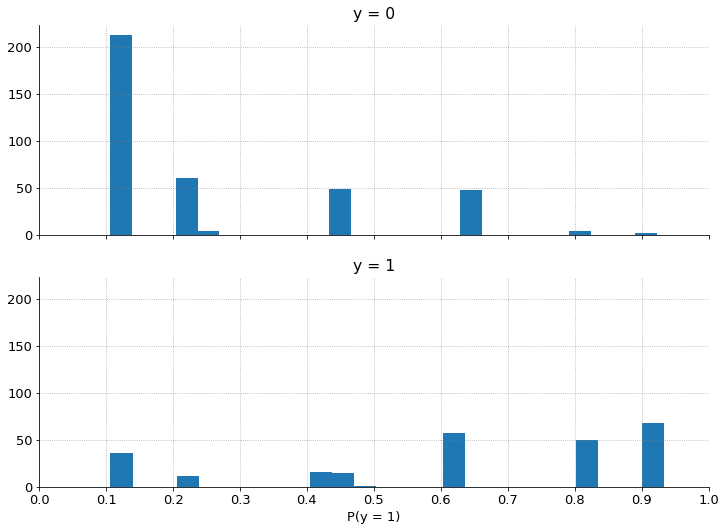

In [16]:
logistic_regression_util.plot_true_by_probs(actual, probs, subplots=True)

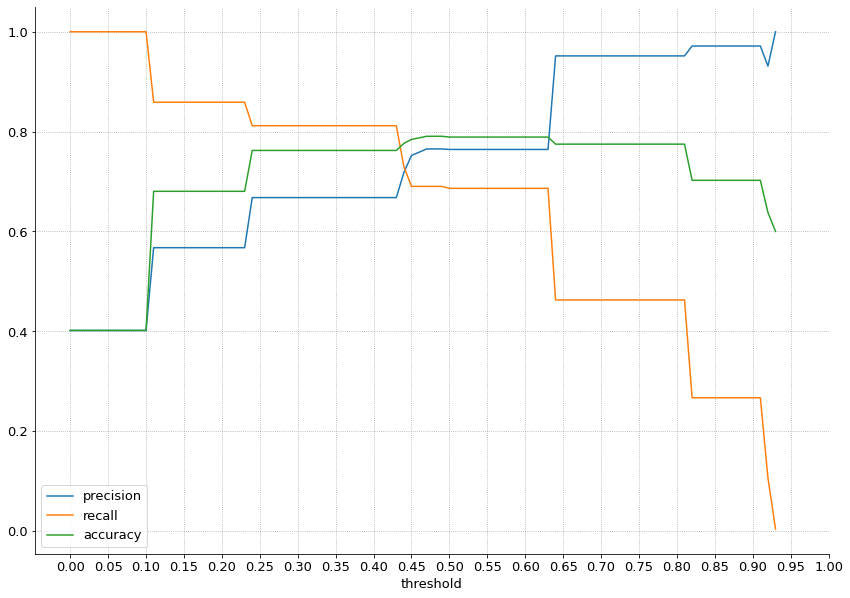

In [17]:
logistic_regression_util.plot_metrics_by_thresholds(actual, probs)

In [18]:
t = .55
probs = model.predict(test)
yhat = (probs > t).astype(int)
actual = test.survived

accuracy_score(actual, yhat)

0.816

# Logistic Regression Exercise

In this exercise, we'll continue working with the titanic dataset and building logistic regression models. Throughout this exercise, be sure you are training, evaluation, and comparing models on the train and validate datasets. The test dataset should only be used for your final model.

In [19]:
titanic = acquire.get_titanic_data()

NameError: name 'acquire' is not defined

In [ ]:
def encode_sex(df):
    '''
    Returns a new dataframe with the ``sex`` column encoded.
    '''
    return df.assign(
        sex=(df.sex == 'female').astype(int)
    )

In [ ]:
def get_splits(titanic):
    '''
    Returns X and y for train, validate and test datasets
    '''
    # don't blow away our original data
    titanic = titanic.copy()
    
    # ignore warnings just for this block
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        scaler, encoder, train, test = prepare.prep_titanic(titanic)
    
    # Which features are we going to look at?
    cols = ['survived', 'pclass', 'sex', 'age', 'alone']
    train = train[cols]
    test = test[cols]

    # validate data split
    train, validate = sklearn.model_selection.train_test_split(
        train, train_size=.85, random_state=123
    )

    # split into X and y
    X_train, y_train = train.drop(columns='survived'), train.survived
    X_validate, y_validate = validate.drop(columns='survived'), validate.survived
    X_test, y_test = test.drop(columns='survived'), test.survived
    
    X_train = encode_sex(X_train)
    X_validate = encode_sex(X_validate)
    X_test = encode_sex(X_test)
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [ ]:
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)

print('   train: %d rows' % X_train.shape[0])
print('validate: %d rows' % X_validate.shape[0])
print('    test: %d rows' % X_test.shape[0])

### Compare Models

In [ ]:
# a dataframe to hold our models' predictions for future comparison
evaluation = pd.DataFrame({
    'actual': y_validate
})

### Model Creation

Note that I've built my notebook such that one cell is one "unit" of model creation.
At the top of every cell I re-call `get_splits` so that I'm free to screw around with the data (e.g. dropping, renaming columns) within that cell, but it will be reset for the next one.
The last step of each cell is storing the model's predictions.

In [ ]:
# survived ~ pclass + age
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)
X_train = X_train.drop(columns=['alone', 'sex'])
X_validate = X_validate.drop(columns=['alone', 'sex'])

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
# [:, 1] -- numpy matrix -- all the rows, just the second column
evaluation['survived ~ pclass + age'] = model.predict_proba(X_validate)[:, 1]

In [ ]:
# survived ~ pclass + age + sex
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)
X_train = X_train.drop(columns=['alone'])
X_validate = X_validate.drop(columns=['alone'])

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
evaluation['survived ~ pclass + age + sex'] = model.predict_proba(X_validate)[:, 1]

In [ ]:
# survived ~ pclass + age + sex + alone
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)
evaluation['survived ~ pclass + age + sex + alone'] = model.predict_proba(X_validate)[:, 1]

In [ ]:
evaluation

- A threshold is a value we choose
- if the probability the model gives us is above the threshold, predict positive
- if the probability the model gives us is below the threshold, predict negative
- `.predict` -- makes predictions with a threshold of .5
- When the threshold is 0, predict everything as positive (i.e. 1)
- When the threshold is 1, predict everything as negative (i.e. 0)

### Evaluation

In [ ]:
logistic_regression_util.plot_metrics_by_thresholds(
    evaluation.actual, evaluation['survived ~ pclass + age']
)

In [ ]:
logistic_regression_util.plot_metrics_by_thresholds(
    evaluation.actual, evaluation['survived ~ pclass + age + sex']
)

In [ ]:
logistic_regression_util.plot_metrics_by_thresholds(
    evaluation.actual, evaluation['survived ~ pclass + age + sex + alone']
)

It looks like the model with more features is better here.

### Choosing a Threshold

Things to consider:

- where is an acceptable balance of the metrics?
- If I'm optimizing for precision/recall, where is a point where accuracy is still good, and the other metrics aren't terrible?
- What is the cost of a false positive vs false negative?

In [ ]:
thresholds = logistic_regression_util.evaluate_thresholds(evaluation.actual, evaluation['survived ~ pclass + age + sex + alone'])
thresholds.sort_values(by='accuracy')

In [ ]:
t = .66

predictions = (evaluation['survived ~ pclass + age + sex + alone'] > t).astype(int)
actual = evaluation.actual

# confusion matrix
pd.crosstab(predictions, actual, normalize=True)

### Exploring the `C` Hyperparameter

Two things:

1. The `C` hyperparameter: can constrain the size of the coefficients
2. The python code

Takeaways:

1. Try experimenting with differing values of `C` on the validate split
2. Choose a lower value for `C` to reduce overfitting (too low of a value might lead to underfitting)
3. If `C` is important, scale your data (regularization works best with scaled data)

In [ ]:
X_train, y_train, X_validate, y_validate, X_test, y_test = get_splits(titanic)

# TODO: allow for a threshold
# TODO: include precision and recall
def evaluate_model(c):
    model = sklearn.linear_model.LogisticRegression(C=c)
    model.fit(X_train, y_train)
    accuracy = model.score(X_validate, y_validate)
    coefs = dict(zip(X_train.columns, model.coef_[0]))
    return {'C': c, 'accuracy': accuracy, **coefs}

models = [evaluate_model(c) for c in [.001, .01, .1, 1, 10, 100, 1000]]
(pd.DataFrame(models).round(3)
 .set_index(['C', 'accuracy'])
 .style
 .set_caption('Effect of differnt C values on accuracy (t=.5) and the resulting coefficients.')
 .set_precision(3)
#  .background_gradient('Blues')
#  .highlight_max() # for columns
#  .highlight_max(axis=1) # for rows
)

In [ ]:
dict(zip(X_train.columns, model.coef_[0]))

5. **Bonus** How do different strategies for handling the missing values in the age column affect model performance?

6. **Bonus**: How do different strategies for encoding sex affect model performance?

7. **Bonus**: scikit-learn's LogisticRegression classifier is actually applying a regularization penalty to the coefficients by default. This penalty causes the magnitude of the coefficients in the resulting model to be smaller than they otherwise would be. This value can be modified with the C hyper parameter. Small values of C correspond to a larger penalty, and large values of C correspond to a smaller penalty.

    Try out the following values for C and note how the coefficients and the model's performance on both the dataset it was trained on and on the validate split are affected.
                                C=.01,.1,1,10,100,1000

**Bonus Bonus**: how does scaling the data interact with your choice of C?

# Decision Tree Exercise

In [ ]:
df = sns.load_dataset("titanic")
df.head()

In [ ]:
# drop duplicate columns
# Drop columns that we discovered from Explore stage didn't really have a lot of bearing
df = df[["survived", "pclass", "sex", "age", "fare"]]
df.head()

In [ ]:
def encode_gender(gender):
    if gender == "male":
        return 0
    else:
        return 1

In [ ]:
df.sex = df.sex.apply(encode_gender)
df.head()

In [ ]:
df.info()

In [ ]:
print(f"Survived nulls: {df.survived.isna().sum()}")
print(f"Class nulls:  {df.pclass.isna().sum()}")
print(f"Gender nulls: {df.sex.isna().sum()}")
print(f"Age nulls: {df.age.isna().sum()}")
print(f"Fare nulls: {df.fare.isna().sum()}")

In [ ]:
# nice and clean
df.isna().sum()

In [ ]:
# get the median age
median_age = df[df.age.notnull()].age.median()
median_age

In [ ]:
# the pandas .median method ignores nulls
df.age.median()

In [ ]:
# fill the nulls w/ the median
df.age = df.age.fillna(median_age)
print(f"Age nulls: {df.age.isna().sum()}")

In [ ]:
# Setup the X and y variables
X = df.drop("survived", axis=1)
y = df[["survived"]]

In [ ]:
# Setup the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

In [ ]:
# for classification you can change the algorithm to gini or entropy (information gain).  Default is gini.
clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=123)

1. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_train)
y_pred

### Model's Predicted Performance

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

In [ ]:
print(classification_report(y_train, y_pred))

### Model Performance on Test Data

In [ ]:
# Get the predicted y values from the X_test
y_pred = clf.predict(X_test)

In [ ]:
print(f"Accuracy of Decision Tree on Test data is: {clf.score(X_test, y_test)}")

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
dot_data = export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 

graph.render('iris_decision_tree', view=True)

# Random Forest Exercises

In [ ]:
df = prep_titanic_data(get_titanic_data())
df.info()

1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 20.

2. Evaluate your results using the model score, confusion matrix, and classification report.
   

3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.
   

4. Run through steps increasing your min_samples_leaf to 5 and decreasing your max_depth to 3.
   

5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?